In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time

from ghost.multisim import GhostSimulator

plt.rcParams['text.usetex'] = True

PSNR: 18.58391301397063
Original image:


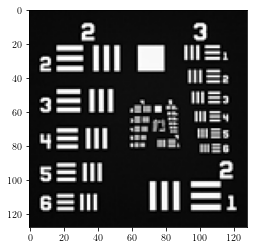

Reconstructed Image


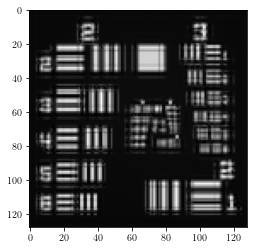

Active area of the camera


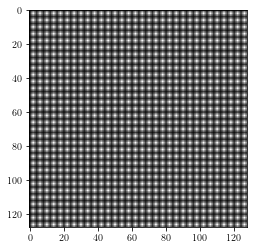

In [106]:
path = '../common/RC_780.png'
slm_res = (128, 128)
camera_res = (32, 32)
mac_res = (4, 4)
sim = GhostSimulator(path, slm_res, camera_res, mac_res, 6, sigma=1, method='zigzag')
cnt = sim.run_simulation()
# rmse = sim.calc_rmse()
# print('RMSE:', rmse)
psnr = sim.calc_psnr()
print('PSNR:', psnr)

print("Reconstructed Image")
plt.imshow(np.abs(sim.G2), cmap='gray')
plt.show()

print("Original image:")
plt.imshow(sim.T, cmap='gray')
plt.show()

# print(np.average(sim.T), np.average(sim.G2))

print("Active area of the camera")
plt.imshow(sim.At.sum(axis=0).reshape(sim.shape_slm), cmap='gray')
plt.show()

generate hadamard matrix


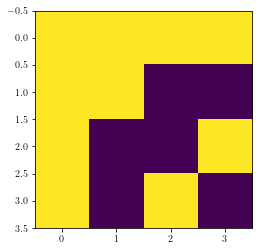

Generate some partial filter


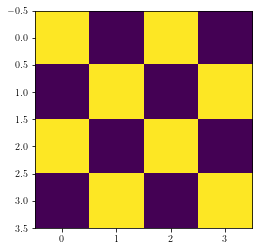

Generate some filter


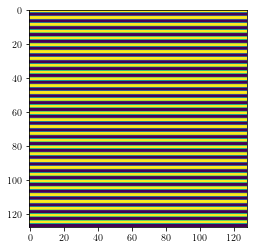

In [108]:
sim = GhostSimulator(path, slm_res, camera_res, (4, 4),  64*64*0.1)
h = sim.generate_hadamard(sim.shape_mac)

print("generate hadamard matrix")
plt.imshow(h)
plt.show()

print("Generate some partial filter")
hp = sim.generate_partial_filter(15)
plt.imshow(hp)
plt.show()

print("Generate some filter")
s = sim.generate_filter(1)
plt.imshow(s)
plt.show()



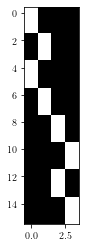

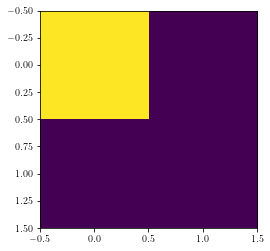

In [161]:
import numpy as np
from math import prod
import cv2

camera_res = (2, 2)
slm_res = (4, 4)

A = np.zeros((prod(slm_res), prod(camera_res)))

for i in range(slm_res[0]):
    for j in range(slm_res[1]):
        slm = np.zeros(slm_res)
        slm[i, j] = 1
        cam = cv2.resize(slm, camera_res, interpolation=cv2.INTER_AREA)
        cam = cam * prod(slm_res) / prod(camera_res)
        A[i*slm_res[1] + j, :] = cam.flatten()

plt.imshow(A, cmap='gray')
plt.show()

plt.imshow(A[5].reshape(camera_res))
plt.show()

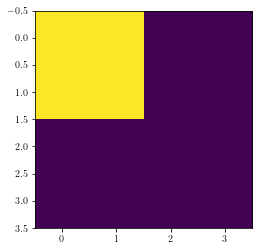

In [39]:
# simulate ideal algo

cam_res = (2, 2)
slm_res = (4, 4)

B = np.zeros(cam_res, dtype=np.ndarray)
for i in range(cam_res[0]):
    for j in range(cam_res[1]):
        B[i, j] = np.zeros(slm_res)
        for u in range(slm_res[0]):
            for v in range(slm_res[1]):
                if u >= i*slm_res[0]/cam_res[0] and u < (i+1)*slm_res[0]/cam_res[0] and v >= j*slm_res[1]/cam_res[1] and v < (j+1)*slm_res[1]/cam_res[1]:
                    B[i, j][u, v] = 1

plt.imshow(B[0,0])
plt.show()


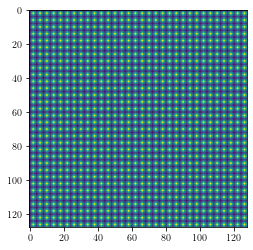

In [107]:
# optimizing gaussian simulation
from math import prod
cam_res = (32, 32)
slm_res = (128, 128)

sigma = 1

mac_res = slm_res[0]/cam_res[0], slm_res[1]/cam_res[1]

At = np.zeros((prod(cam_res), prod(slm_res)))
for i in range(prod(cam_res)):
        u, v = i // cam_res[1], i % cam_res[1]
        x = np.arange(0, slm_res[0], 1)
        y = np.arange(0, slm_res[1], 1)
        xv, yv = np.meshgrid(x, y)
        xy = (xv - (u+0.5)*mac_res[0])**2 + (yv - (v+0.5)*mac_res[1])**2
        temp = 1/(2*np.pi*sigma**2)*np.exp(-xy/(2*sigma**2))
        At[i] = temp.flatten()

S = At.T.sum(axis=1, keepdims=True)
A = At.T/S

# plt.imshow(At[0].reshape(slm_res))
# plt.show()

plt.imshow(At.sum(axis=0).reshape(slm_res))
plt.show()